In [1]:
import numpy as np
import pandas as pd
import json
import io
import os
import sys
import pickle
import math
import random
from time import time

import matplotlib.pyplot as plt

In [3]:
def EMD(Z_i, Z_global):
    magnitude = lambda vector: math.sqrt(sum(pow(element, 2) for element in vector))
    return magnitude(Z_i/magnitude(Z_i) - Z_global/magnitude(Z_global))


NO_CLIENTS = 56
NO_GROUPS = 7
NO_CLASSES = 10
ALPHA = "03"

replace_dict = {
    0: 7,
    1: 6,
    2: 5,
    3: 4,
    4: 3,
    5: 2,
    6: 1,
}

path = f"../data/alpha/Cifar10_NIID_{NO_CLIENTS}c_a{ALPHA}/config.json"
conf = json.loads(open(path, "r").read())
data = [dict(zip(np.array(cli)[:,0], np.array(cli)[:,1])) for cli in conf["Size of samples for labels in clients"]]

main_label_vectors = np.zeros((NO_CLIENTS,NO_CLASSES))
for client_id in range(NO_CLIENTS):
    for class_id in range(NO_CLASSES):
        if class_id in data[client_id].keys():
            main_label_vectors[client_id][class_id] = data[client_id][class_id]

def spread_bw_random(main_label_vectors, no_clients, tiers):
    NO_CLIENTS = no_clients
    # weak    = 2_500_000
    # normal = 35_000_000
    # strong  = 80_000_000


    # low_count = int(10/56*NO_CLIENTS)
    # high_count = int(10/56*NO_CLIENTS)
    # medium_count = NO_CLIENTS - low_count - high_count

    # bw_types = (["low"]*low_count) + (["medium"]*medium_count) + (["high"]*high_count)

    
    bw_types = []
    bw = []
    for k, v in tiers.items():
        for i in range(int(NO_CLIENTS / len(tiers))):
            bw_types.append(k)
            bw.append(random.choice(tiers[k]))

    # lows = [weak] * low_count
    # mediums = [normal] * medium_count
    # highs = [strong] * high_count
    # bw = lows + mediums + highs

    print(int(NO_CLIENTS / len(tiers)))
    print(len(bw))
    print(len(bw_types))

    ids = np.arange(NO_CLIENTS)
    random.shuffle(ids)

    bws = []
    for idx in ids:
        bws.append((bw[idx],bw_types[idx]))

    clients_list = []
    for idx in range(len(main_label_vectors)):
        clients_list.append(
            {
                "client_id" : idx,
                "bw" : bws[idx][0],
                "bw_type" : bws[idx][1],
                "distribution" : main_label_vectors[idx],
                "group" : None
            }
        )

    clients_df = pd.DataFrame(clients_list)

    maindf = clients_df.sort_values("bw")
    maindf["group"] = np.repeat(np.arange(7),int(NO_CLIENTS / NO_GROUPS))


    for idx,row in maindf.iterrows():
        maindf.at[idx,"group"] = replace_dict[row.group]
        # maindf.at[idx,"distribution"] = np.array([float(item) for item in row.distribution.replace("[","").replace("]","").split(" ") if item != ""])
        
    maindf.reset_index(drop=True)

    return maindf

In [4]:
# maindf = pd.read_csv("../data/bws_groups.csv", index_col=0)

def vis_bw_counts(maindf, no_clients, no_groups):

    member_per_group = int(no_clients / no_groups)
    print(member_per_group)

    x = np.array(np.meshgrid(np.arange(1,no_groups+1),np.arange(1,member_per_group+1))).T.reshape(-1,2)[:,0]
    y = np.array(np.meshgrid(np.arange(1,no_groups+1),np.arange(1,member_per_group+1))).T.reshape(-1,2)[:,1]
    s = np.ones((no_groups,member_per_group))*(600/8*member_per_group)
    
    tiers = [[] for i in range(no_groups)]
    for group_name, group_df in maindf.groupby("group"):
        tiers[group_name-1] = group_df["bw_type"].tolist()


    circle_size = member_per_group/600 * 8
    circle_size = 10000
    s_low = []
    for group_no in range(no_groups):
        s_low.append([])
        for client_no in range(member_per_group):
            tier = tiers[group_no][client_no]
            if tier == "low": size = circle_size
            else: size = 0
            s_low[group_no].append(size)

    s_medium = []
    for group_no in range(no_groups):
        s_medium.append([])
        for client_no in range(member_per_group):
            tier = tiers[group_no][client_no]
            if tier == "medium": size = circle_size
            else: size = 0
            s_medium[group_no].append(size)

    s_high = []
    for group_no in range(no_groups):
        s_high.append([])
        for client_no in range(member_per_group):
            tier = tiers[group_no][client_no]
            if tier == "high": size = circle_size
            else: size = 0
            s_high[group_no].append(size)


    plt.figure(figsize=(10,5))
    plt.scatter(x, y, s_low,    c="brown",      label="Low Bandwidth Client")
    plt.scatter(x, y, s_medium, c="orange",     label="Medium Bandwidth Client")
    plt.scatter(x, y, s_high,   c="limegreen",  label="High Bandwidth Client")
    plt.legend(loc="upper center", ncol=3)
    plt.ylim(0.5,9.5)
    plt.yticks(np.arange(1,member_per_group+1))
    plt.xlabel("Group No (Pruned Model No)")
    plt.ylabel("Clients")
    plt.show()

# vis_bw_counts(df_final, 210, 7)

In [5]:
def vis_group_dist(df):

    class_dist = []
    for group_name, group_df in df.groupby("group"):
        class_dist.append(np.sum(group_df.distribution.tolist(),axis=0))
    
    class_dist = np.array(class_dist)

    x = np.array(np.meshgrid(np.arange(1,8),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,0]
    y = np.array(np.meshgrid(np.arange(1,8),np.arange(NO_CLASSES))).T.reshape(-1,2)[:,1]
    s = class_dist.reshape(1,-1)[0]
    s = ((s - np.amin(s))/(np.amax(s) - np.amin(s))*600).astype("int")
    plt.scatter(x,y,s)
    plt.yticks(np.arange(10))
    plt.xlabel("Group ID")
    plt.ylabel("Class")
    plt.show()

In [6]:
def transfer_op(df_iter, candidate_operations, selected_idx):
    selected_operation = candidate_operations[selected_idx]

    df_dict = df_iter.to_dict(orient="index")
    main_group = df_dict[selected_operation[0]]["group"]
    other_group = df_dict[selected_operation[1]]["group"]

    df_iter.at[selected_operation[0], "group"] = other_group
    df_iter.at[selected_operation[1], "group"] = main_group

    return df_iter

def average_EMD(df_iter, global_dist):
    EMDs = []
    for group_name, group_df in df_iter.groupby("group"):
        EMDs.append(EMD(np.sum(group_df.distribution.values, axis=0), global_dist))
    return np.mean(EMDs)

def NetDag(maindf, no_groups, coeff, max_iter, viz=False):
    global_dist = np.sum(maindf.distribution.values, axis=0)
    df_iter = maindf.copy()

    COEFF = coeff
    NO_GROUPS = no_groups
    down_durs = []
    all_scores = []
    scores = []
    emds = []
    for group_no in range(NO_GROUPS,0,-1):
        group_selected = df_iter[df_iter["group"] == group_no]
        group_dist = np.sum(group_selected.distribution.values, axis=0)
        scores.append(EMD(group_dist, global_dist))
    all_scores.append(scores)


    seq_of_move = np.arange(1,NO_GROUPS+1).tolist()

    for iter_no in range(max_iter):
        no_operations_done = 0
        # for group_no in range(NO_GROUPS,0,-1):
        # seq_of_move = sorted(np.arange(1,NO_GROUPS+1), key=lambda k: random.random())
        seq_of_move = seq_of_move[1:] + seq_of_move[: 1]
        # print(seq_of_move)
        for group_no in seq_of_move:
            current_emd = average_EMD(df_iter, global_dist)
            group_selected = df_iter[df_iter["group"] == group_no]
            
            group_friend_next = df_iter[df_iter["group"] == group_no-1]
            group_friend_prev = df_iter[df_iter["group"] == group_no+1]

            group_friend_next_2 = df_iter[df_iter["group"] == group_no-2]
            group_friend_prev_2 = df_iter[df_iter["group"] == group_no+2]

            candidate_groups = [
                group_friend_next,
                group_friend_prev,
                group_friend_next_2,
                group_friend_prev_2
                ]

            group_dist = np.sum(group_selected.distribution.to_numpy(), axis=0)
            score = EMD(group_dist, global_dist)
            candidate_operations = []
            bw_debug = []
            for idx, row in group_selected.iterrows():
                client_id = row.client_id
                group_dist_wo = group_dist - np.array(row.distribution)
                bw_type = row.bw_type

                for candidate_group in candidate_groups:
                    for idx2, row2 in candidate_group.iterrows():
                        candidate_dist = group_dist_wo + np.array(row2.distribution)
                        candidate_score = EMD(candidate_dist ,global_dist)
                        bw_type_candidate = row2.bw_type
                        if bw_type == bw_type_candidate: coeff = 1
                        else:
                            # coeff = COEFF**(iter_no+1)
                            coeff = COEFF

                        if candidate_score < score*coeff:

                            df_iter_temp = transfer_op(df_iter.copy(), [(client_id, row2.client_id, candidate_score)], -1)
                            avg_emd = average_EMD(df_iter_temp, global_dist)
                            emds.append(avg_emd)

                            # candidate_operations.append((client_id, row2.client_id, candidate_score))
                            candidate_operations.append((client_id, row2.client_id, avg_emd))
                            bw_debug.append((bw_type, bw_type_candidate))


            # Transfer operation            
            candidate_operations = np.array(candidate_operations)
            if len(candidate_operations) > 0:
                selected_idx = np.argmin(candidate_operations[:,2])
                if current_emd > candidate_operations[selected_idx,2]:
                    # print(candidate_operations[selected_idx], bw_debug[selected_idx])
                    df_iter = transfer_op(df_iter, candidate_operations, selected_idx)
                    no_operations_done += 1

        scores = []
        for group_no in range(NO_GROUPS,0,-1):
            group_selected = df_iter[df_iter["group"] == group_no]
            group_dist = np.sum(group_selected.distribution.to_numpy(), axis=0)
            scores.append(EMD(group_dist, global_dist))
        all_scores.append(scores)

        down_durs.append(download_duration(df_iter))

        if viz: print(f"## ITER {iter_no} | No operations done : {no_operations_done}")
        if no_operations_done == 0:
            break

    all_scores = np.array(all_scores)



    if viz:
        vis_group_dist(df_iter)
        vis_bw_counts(df_iter, len(maindf), NO_GROUPS)

        ### EMD CHANGE
        ax = plt.subplots(figsize=(10,5))
        for group_no in range(NO_GROUPS):
            plt.plot(np.arange(1,len(all_scores)+1), all_scores[:,group_no], label=f"Group {group_no+1}", linewidth=2)
        plt.xlabel("Iteration")
        plt.ylabel("EMD")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,3))
        plt.boxplot(all_scores.T)
        plt.xlabel("Iteration")
        plt.ylabel("EMD")
        plt.show()
    
    return df_iter, all_scores, iter_no, down_durs

In [7]:
def download_duration(df_final):
    model_sizes = {
        1: 227108578,
        2: 226817122,
        3: 226559010,
        4: 226595938,
        5: 198579234,
        6: 172803362,
        7: 176866594,
    }

    bw_df = df_final[["bw","group"]].groupby("group").min()
    bw_df["mb"] = model_sizes.values()

    return np.amax(bw_df["mb"] / (bw_df["bw"] / 8))
    

4
56
56
## ITER 0 | No operations done : 6
## ITER 1 | No operations done : 4
## ITER 2 | No operations done : 1
## ITER 3 | No operations done : 0


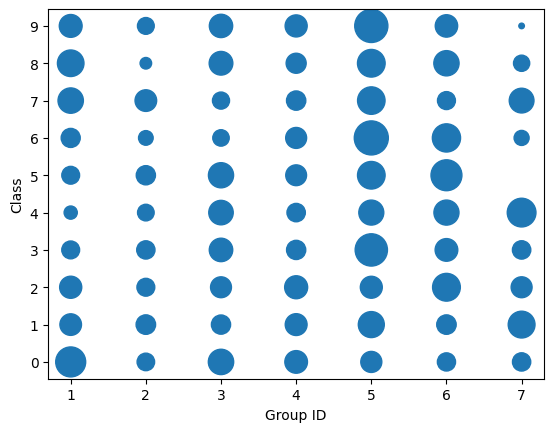

8


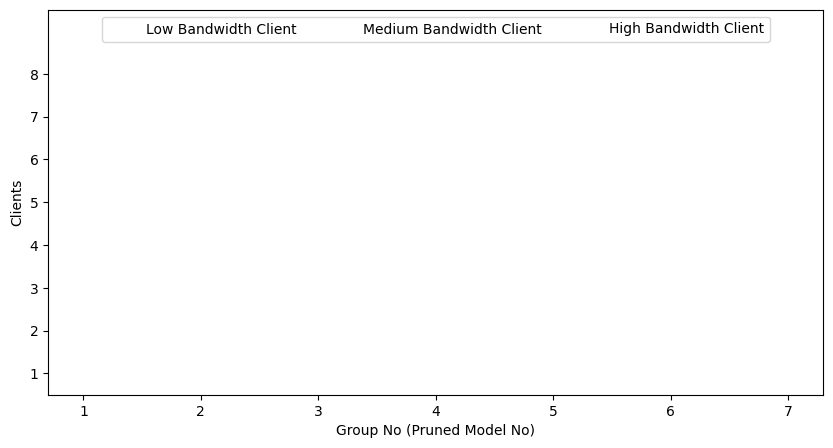

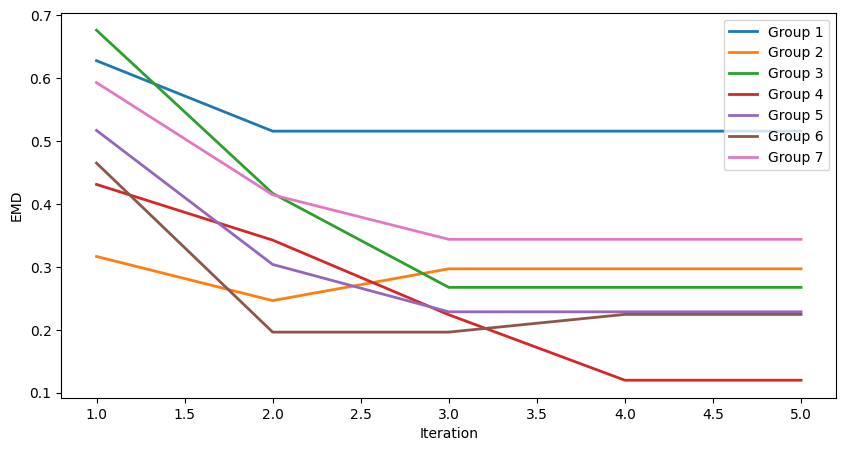

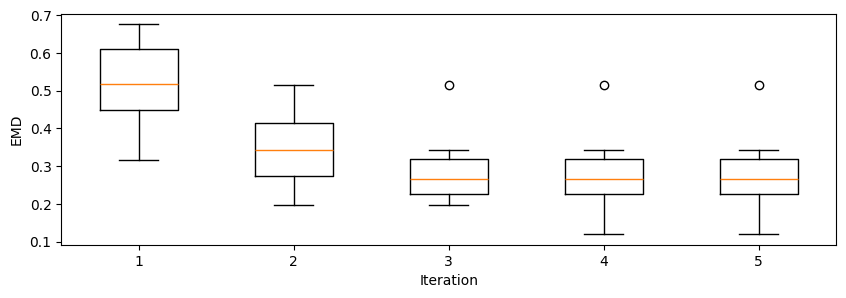

ALGO: 0.9612014293670654


,alpha,no_clients,coeff,max_iter,initial_emd,emd,final_iter,download_duration,avg_elapsed_time
0,0.3,56,0.8,20,0.517932,0.28508,3,471.644251,0.959099


In [12]:
main_label_vectors

import random

NO_CLIENTS = 56
NO_GROUPS = 7
NO_CLASSES = 10
ALPHA = "03"

replace_dict = {
    0: 7,
    1: 6,
    2: 5,
    3: 4,
    4: 3,
    5: 2,
    6: 1,
}

model_sizes = {
    1: 227108578,
    2: 226817122,
    3: 226559010,
    4: 226595938,
    5: 198579234,
    6: 172803362,
    7: 176866594,
}

def main(no_clients, no_groups, alpha, coeff, max_iter, no_classes=10, no_tests=20, viz=False):
    NO_CLIENTS = no_clients
    NO_GROUPS = no_groups
    NO_CLASSES = no_classes
    if isinstance(alpha, float): ALPHA = f"{alpha}".replace(".","")
    elif isinstance(alpha, str): ALPHA = alpha
    COEFF = coeff
    MAX_ITER = max_iter

    # tiers = {
    #     "TIER_11" : random.choice(np.array([2_500_000, 3_500_000, 500_000])),
    #     "TIER_12" : random.choice(np.array([4_000_000, 5_500_000, 500_000])),
    #     "TIER_13" : random.choice(np.array([6_000_000, 8_000_000, 500_000])),

    #     "TIER_21" : random.choice(np.array([8_500_000, 12_500_000, 1_000_000])),
    #     "TIER_22" : random.choice(np.array([13_000_000, 16_500_000, 1_000_000])),
    #     "TIER_23" : random.choice(np.array([17_000_000, 25_000_000, 1_000_000])),
    #     "TIER_24" : random.choice(np.array([25_500_000, 32_500_000, 1_000_000])),

    #     "TIER_31" : random.choice(np.array([35_000_000, 40_000_000, 1_000_000])),
    #     "TIER_32" : random.choice(np.array([41_000_000, 55_000_000, 1_000_000])),
    #     "TIER_33" : random.choice(np.array([56_000_000, 75_000_000, 1_000_000])),
    #     "TIER_34" : random.choice(np.array([75_000_000, 100_000_000, 1_000_000])),

    #     "TIER_41" : random.choice(np.array([100_000_000, 400_000_000, 20_000_000]))
    # }

    tiers = {
        "TIER_11" : np.arange(2_500_000, 3_500_000, 500_000),
        "TIER_12" : np.arange(4_000_000, 5_500_000, 500_000),
        "TIER_13" : np.arange(6_000_000, 8_000_000, 500_000),

        "TIER_21" : np.arange(8_500_000, 12_500_000, 1_000_000),
        "TIER_22" : np.arange(13_000_000, 16_000_000, 1_000_000),
        "TIER_23" : np.arange(17_000_000, 25_000_000, 1_000_000),
        "TIER_24" : np.arange(26_000_000, 30_000_000, 1_000_000),
        "TIER_25" : np.arange(31_000_000, 34_000_000, 1_000_000),

        "TIER_31" : np.arange(35_000_000, 40_000_000, 1_000_000),
        "TIER_32" : np.arange(41_000_000, 55_000_000, 1_000_000),
        "TIER_33" : np.arange(46_000_000, 65_000_000, 1_000_000),
        "TIER_34" : np.arange(66_000_000, 75_000_000, 1_000_000),
        "TIER_35" : np.arange(75_000_000, 100_000_000, 1_000_000),

        "TIER_41" : np.arange(100_000_000, 400_000_000, 20_000_000)
    }

    

    path = f"../data/alpha/Cifar10_NIID_{NO_CLIENTS}c_a{ALPHA}/config.json"
    conf = json.loads(open(path, "r").read())
    data = [dict(zip(np.array(cli)[:,0], np.array(cli)[:,1])) for cli in conf["Size of samples for labels in clients"]]

    main_label_vectors = np.zeros((NO_CLIENTS,NO_CLASSES))
    for client_id in range(NO_CLIENTS):
        for class_id in range(NO_CLASSES):
            if class_id in data[client_id].keys():
                main_label_vectors[client_id][class_id] = data[client_id][class_id]

    final_scores = []
    durations = []
    for i in range(no_tests):
        s = time()
        maindf = spread_bw_random(main_label_vectors, NO_CLIENTS, tiers)
        maindf.to_csv(os.path.join(f"../data/alpha/Cifar10_NIID_{NO_CLIENTS}c_a{ALPHA}/","bws_groups.csv"))
        df_final, all_scores, iter_no, down_durs = NetDag(maindf, NO_GROUPS, COEFF, MAX_ITER, viz=viz)
        final_scores.append(np.mean(all_scores[-1]))
        durations.append(time() - s)

    return df_final, all_scores, final_scores, iter_no, down_durs, np.mean(durations)


logs = []

no_tests = 20
no_clients = 56
alpha = 0.3
coeff = 0.8
max_iter = 20
s = time()

df_final, all_scores, final_scores, iter_no, down_durs, avg_elapsed = main(
    no_clients=no_clients,
    no_groups=7,
    alpha=alpha,
    coeff=coeff,
    max_iter=max_iter,
    no_tests=1,
    viz=True
)
avgEMD = np.mean(all_scores[-1])
lastDur = down_durs[-1]

log = {
    "alpha": alpha,
    "no_clients" : no_clients,
    "coeff": coeff,
    "max_iter": max_iter,
    "initial_emd": np.mean(all_scores[0]),
    "emd": avgEMD,
    "final_iter": iter_no,
    "download_duration": lastDur,
    "avg_elapsed_time": avg_elapsed
}
logs.append(log)
print("ALGO:", time() - s)
s = time()

log_df = pd.DataFrame(logs)
# log_df.to_csv("../data/alpha/test_03.csv")
# print("WRITE:", time() - s)
log_df

In [17]:
tiers = {
        "TIER_11" : np.arange(2_500_000, 3_500_000, 500_000),
        "TIER_12" : np.arange(4_000_000, 5_500_000, 500_000),
        "TIER_13" : np.arange(6_000_000, 8_000_000, 500_000),

        "TIER_21" : np.arange(8_500_000, 12_500_000, 1_000_000),
        "TIER_22" : np.arange(13_000_000, 16_000_000, 1_000_000),
        "TIER_23" : np.arange(17_000_000, 25_000_000, 1_000_000),
        "TIER_24" : np.arange(26_000_000, 30_000_000, 1_000_000),
        "TIER_25" : np.arange(31_000_000, 34_000_000, 1_000_000),

        "TIER_31" : np.arange(35_000_000, 40_000_000, 1_000_000),
        "TIER_32" : np.arange(41_000_000, 55_000_000, 1_000_000),
        "TIER_33" : np.arange(46_000_000, 65_000_000, 1_000_000),
        "TIER_34" : np.arange(66_000_000, 75_000_000, 1_000_000),
        "TIER_35" : np.arange(75_000_000, 100_000_000, 1_000_000),

        "TIER_41" : np.arange(100_000_000, 400_000_000, 20_000_000)
    }

assignment = {
    "block_0": {},
    "block_1": {},
    "block_2": {},
    "block_3": {},
    "block_4": {},
    "block_5": {},
    "block_6": {},
}
for groupname, groupdf in df_final.groupby("group"):
    for idx, row in groupdf.reset_index().iterrows():
        assignment[f"block_{groupname-1}"][idx] = row.bw_type

with open(f"../data/alpha/Cifar10_NIID_{no_clients}c_a{str(alpha).replace('.','')}/client_groups.json","w") as f:
    json.dump(assignment,f)

In [17]:
pd.read_csv(os.path.join(f"../data/alpha/Cifar10_NIID_{no_clients}c_a{str(alpha).replace(".","")}/","bws_groups.csv"))

,Unnamed: 0,client_id,bw,bw_type,distribution,group
0,69,69,2500000,TIER_11,[118. 36. 145. 0. 0. 0. 0. 0. 0. ...,7
1,176,176,2500000,TIER_11,[ 4. 1. 0. 0. 2. 1. 0. 430. 0. ...,7
2,24,24,2500000,TIER_11,[ 6. 0. 11. 0. 305. 0. 0. 0. 0. ...,7
3,16,16,2500000,TIER_11,[ 66. 249. 0. 0. 0. 0. 0. 0. 0. ...,7
4,131,131,2500000,TIER_11,[ 3. 66. 5. 3. 1. 19. 21. 5. 1. 92.],7
...,...,...,...,...,...,...
205,134,134,320000000,TIER_41,[ 0. 74. 7. 21. 54. 0. 9. 15. 112. ...,1
206,201,201,320000000,TIER_41,[253. 1. 2. 44. 0. 0. 0. 0. 0. ...,1
207,30,30,340000000,TIER_41,[448. 0. 0. 0. 0. 0. 0. 0. 0. ...,1
208,66,66,360000000,TIER_41,[11. 91. 0. 3. 62. 1. 21. 5. 1. 0.],1


In [63]:
f"../data/alpha/Cifar10_NIID_{no_clients}c_a{str(alpha).replace(".","")}/client_groups.json"

'../data/alpha/Cifar10_NIID_210c_a03/client_groups.json'

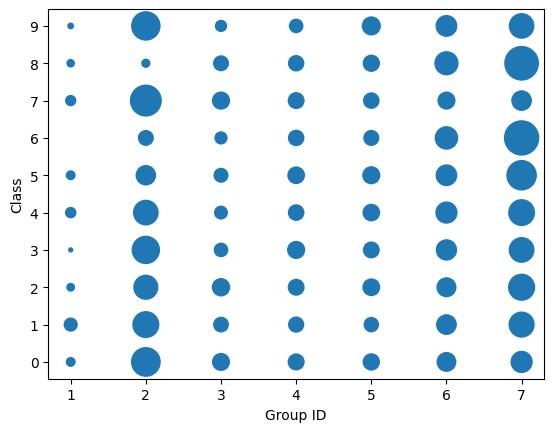

30


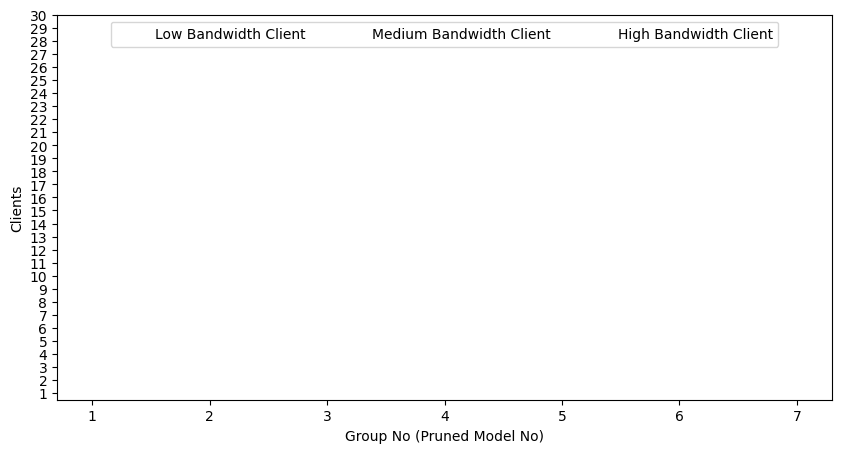

[565.9731008,
 635.4535488,
 635.4535488,
 725.8147904,
 725.8147904,
 725.8147904,
 725.8147904,
 725.8147904,
 725.8147904,
 725.8147904,
 725.8147904,
 725.8147904]

In [39]:
vis_group_dist(df_final)
vis_bw_counts(df_final, len(df_final), NO_GROUPS)

down_durs

## ITER 0 | No operations done : 7
## ITER 1 | No operations done : 7
## ITER 2 | No operations done : 6
## ITER 3 | No operations done : 7
## ITER 4 | No operations done : 6
## ITER 5 | No operations done : 5
## ITER 6 | No operations done : 5
## ITER 7 | No operations done : 2
## ITER 8 | No operations done : 2
## ITER 9 | No operations done : 0


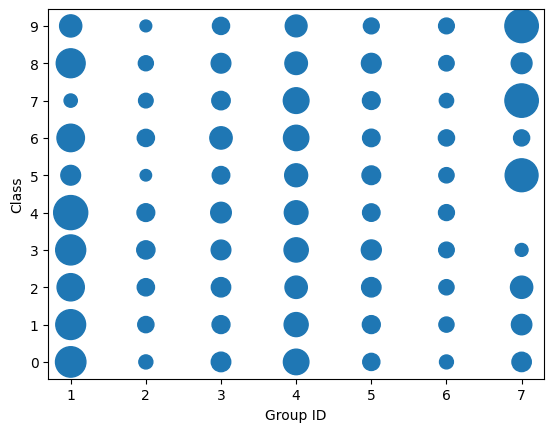

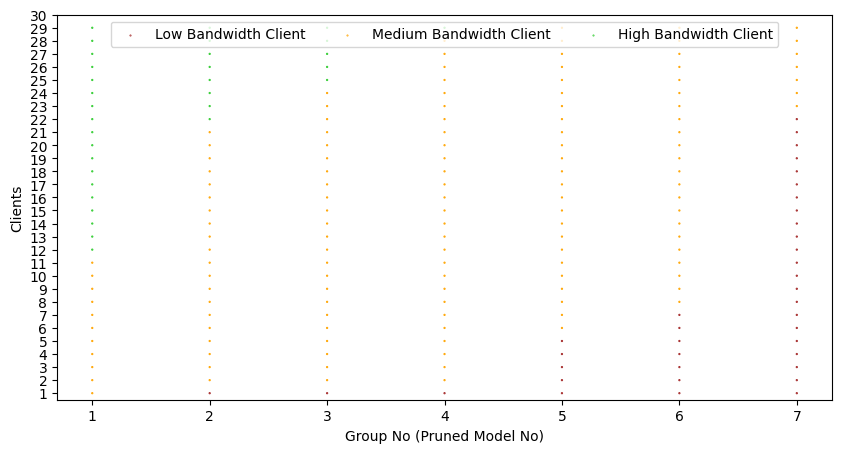

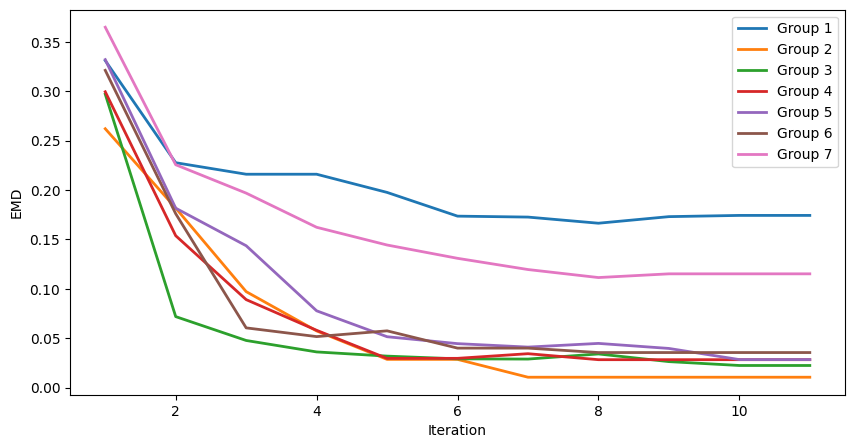

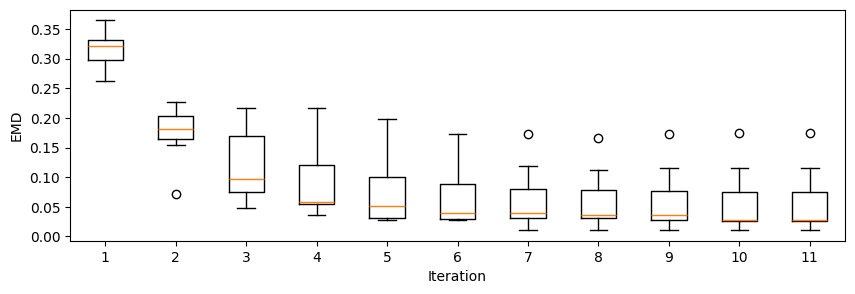

In [121]:
df_final, all_scores, final_scores, iter_no = main(
    no_clients=210,
    no_groups=7,
    alpha=0.3,
    coeff=0.9,
    max_iter=1000,
    viz=True,
    no_tests=1
)